# Adversarial Search: Playing Dots and Boxes


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play the game Dots and Boxes:

> "Dots and Boxes is a pencil-and-paper game for two players. The game starts with an empty grid of dots. Usually two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. A player who completes the fourth side of a 1x1 box earns one point and takes another turn. A point is typically recorded by placing a mark that identifies the player in the box, such as an initial. The game ends when no more lines can be placed. The winner is the player with the most points. The board may be of any size grid." (see [Dots and Boxes on Wikipedia](https://en.wikipedia.org/wiki/Dots_and_Boxes))

You can play Dots and Boxes [here](https://www.math.ucla.edu/~tom/Games/dots&boxes.html).

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem associated with this game:

* **Initial state**
  * Board with no lines connecting any dots.
* **Actions**
  * Draw a line connecting two dots.
* **Transition model**
  * results(s, a) = s’
  * Drawing a line will result in the board having a new line connecting two previously unconnected dots. The transition model takes care of initials in boxes.
* **Test for the terminal state**
  * ----------------------------------------------------------------------------------------------------------------------------------------
* **Utility for terminal states**
  * ----------------------------------------------------------------------------------------------------------------------------------------

**n = number of dots in a column of the board**
**k = n - 1**
1. How big is the state space? Give an estimate and explain it.<br/>
    The state space must account for all lines and know if they are drawn or not, which can be calculated with the following formula: 2^(n*k + n*k).<br/>
    It must also account for the drawn boxes and who owns them (the player or the opponent), which can be found with: 2^(k^2).<br/>
    Therefore, the total state spaace is **2^(n*k + n*k) + 2^(k^2)**

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [1]:
# Your code/ answer goes here.------------------------------------------------------------------------------------------------------------

## Task 2: Game Environment and Random Agent [30 point]

You need to think about a data structure to represent the board meaning he placed lines and who finished what box. There are many options. Let's represent the board using a simple dictionary where `n` and `m` represents the number of dots horizontaly and vertically, respectively. Everybody needs to use the same representation so we can let agents play against each other later. 

In [190]:
import numpy as np

board = {
    'n': 4,  ### hoizontal dots
    'm': 4,   ### vertical dots
    1: 0,   ### number of squares for player 1
    -1: 0    ### number of squares for player 2
}

def empty_board():
    return {
            'n': 4,  ### hoizontal dots
            'm': 4,   ### vertical dots
            1: 0,   ### number of squares for player 1
            -1: 0   ### number of squares for player 2
            }
    
def empty_small():
    return {
            'n': 3,  ### hoizontal dots
            'm': 3,   ### vertical dots
            1: 0,   ### number of squares for player 1
            -1: 0   ### number of squares for player 2
            }

def full_board():
    board = empty_board()
    for row in range(board['n']):
        for col in range(board['m']):
            if col < board['m']-1:
                draw_line(board, 'h', row+1, col+1, np.random.choice((-1, 1)))
            if row >= 1:
                draw_line(board, 'v', row+1, col+1, np.random.choice((-1, 1)))
    return board

def draw_line(board, orientation, row, col, player):
    """
    Place a line on an exiting board.
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    player: str
        Either -1 or +1, representing the player adding the line
    """
    if orientation not in ['h', 'v']:
        return False
    
    if player != -1 and player != 1:
        return False
        
    if row < 0 or col < 0:
        return False
        
    if row >= (board['n']+1) + (orientation == 'v') or col >= (board['m']+1) + (orientation == 'h'):
        return False
        
    if (orientation, row, col) in board:
        return False
    
    board[(orientation, row, col)] = True
    
    # Check if the line closes a box
    line = (orientation, row, col)
    
    # Go through all cases
    if line[0] == 'h':
        # Case 1: horizontal line at bottom
        if ('v', line[1]+1, line[2]) in board and ('v', line[1]+1, line[2]+1) in board and ('h', line[1]+1, line[2]) in board:
            # Add point to player
            board[player] += 1
            # Add box ownership to player
            board[(line[1]+1, line[2])] = player
        
        # Case 2: horizontal line at top
        if ('v', line[1], line[2]) in board and ('v', line[1], line[2]+1) in board and ('h', line[1]-1, line[2]) in board:
            # Add point to player
            board[player] += 1
            # Add box ownership to player
            board[(line[1], line[2])] = player
    
    if line[0] == 'v':
        # Case 3: vertical line at left
        if ('h', line[1], line[2]) in board and ('v', line[1], line[2]+1) in board and ('h', line[1]-1, line[2]) in board:
            # Add point to player
            board[player] += 1
            # Add box ownership to player
            board[(line[1], line[2])] = player
        
        # Case 4: vertical line at right
        if ('h', line[1], line[2]-1) in board and ('v', line[1], line[2]-1) in board and ('h', line[1]-1, line[2]-1) in board:
            # Add point to player
            board[player] += 1
            # Add box ownership to player
            board[(line[1], line[2]-1)] = player
    
    return True

Write code to display the board. **Bonus point: Post your visualization code with an example output to the discussion board. The best visualization will earn you bonus participation points in this class.**

In [3]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def print_board(board):
    n = board['n']
    m = board['m']
    
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, m-0.5)
    ax.set_ylim(-0.5, n-0.5)
    
    # Draw dots
    for row in range(n):
        for col in range(m):
            if (row, col) in board:
                ax.scatter(row, col, s=100, marker='o', color='black')
            else:
                ax.scatter(row, col, s=100, marker='o', color='black')
     
    # Draw lines
    for line in board:
        # print(line)
        if line != 'n' and line != 'm' and line != -1 and line != 1:
            # print(line)
            if len(line) > 2:
                # Draw Horizontal line
                if line[0] == 'h':
                    l = mlines.Line2D([line[2]-1,line[2]], [line[1]-1,line[1]-1], color='black')
                    # l = mlines.Line2D([line[1],line[1]], [line[2],line[2]+1], color='black')
                    ax.add_line(l)
                # Draw Vertical line
                else:
                    l = mlines.Line2D([line[2]-1,line[2]-1], [line[1]-1,line[1]-2], color='black')
                    # l = mlines.Line2D([line[1],line[1]-1], [line[2],line[2]], color='black')
                    ax.add_line(l)
    
    # Check for boxes
    # Boxes are stored in board with (row, col) as key and player (1 or -1) as value
    for box in board:
        if box != 'n' and box != 'm' and box != -1 and box != 1:
            if len(box) == 2:
                if board[(box[0], box[1])] == 1:
                    ax.add_patch(plt.Rectangle((box[1]-1, box[0]-2), 1, 1, color='b'))
                else:
                    ax.add_patch(plt.Rectangle((box[1]-1, box[0]-2), 1, 1, color='r'))
    
    # Print results   
    print('Results:')
    print('         -1:', board[-1])
    print('          1:', board[1])
    
    # Set up plot to start at (1, 1)
    x = []
    y = []
    for row in range(board['n']):
        # x.append(row)
        x.append(row+1)
    for col in range(board['m']):
        # y.append(col)
        y.append(col+1)
    default_x_ticks = range(len(x))
    plt.xticks(default_x_ticks, x)
    default_y_ticks = range(len(y))
    plt.yticks(default_y_ticks, y)
    
    plt.show()

Results:
         -1: 5
          1: 4


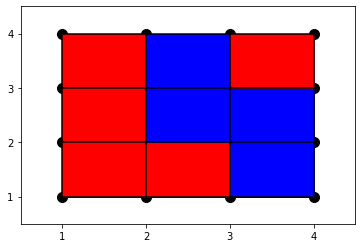

In [4]:
# Example of a board
print_board(full_board())

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

__Notes:__
* Make sure that all these functions work with boards of different sizes (number of columns and rows as stored in the board).
* The result function evaluates if the player closed a box and needs to store that information on the board. Add elements of the form `(row,col): player` to the board dictionary. `row` and `col` are the coordinates for the box and `player` is +1 or -1 representing the player. For example `(0,0): -1` means that the top-left box belongs to the other player. 

In [7]:
def closed_box(state, action, player=1):
    """
    Check if the action closed a box, return True if it did.
    
    Parameters
    ----------
    board: dict
        The board
    action: list
        List describing the action
        action[0]: orientation - 'h' or 'v'
        action[1]: row
        action[2]: column
    """
    
    state = state.copy()
    
    draw_line(state, action[0], action[1], action[2], player)
    
    if action[0] == 'h':
        # Case 1: horizontal line at bottom
        if ('v', action[1]+1, action[2]) in state and ('v', action[1]+1, action[2]+1) in state and ('h', action[1]+1, action[2]) in state:
            # print(action, ' Case 1')
            return True
        # Case 2: horizontal line at top
        if ('v', action[1], action[2]) in state and ('v', action[1], action[2]+1) in state and ('h', action[1]-1, action[2]) in state:
            # print(action, ' Case 2')
            return True
    if action[0] == 'v':
        # Case 3: vertical line at left
        if ('h', action[1], action[2]) in state and ('v', action[1], action[2]+1) in state and ('h', action[1]-1, action[2]) in state:
            # print(action, ' Case 3')
            return True
        # Case 4: vertical line at right
        if ('h', action[1], action[2]-1) in state and ('v', action[1], action[2]-1) in state and ('h', action[1]-1, action[2]-1) in state:
            # print(action, ' Case 4')
            return True
    
    return False

def result(state, action, player=1, agent=random_player):
    '''
    Place a line on the state received. Keeps placing lines if player
    closes a box. Only stops once the new line does not close a box or
    there are no more lines to place.
       
    Parameters
    ----------
    state: dict
        the board
    action: tuple
        (orientation, row, col)
    player: int
        -1 or +1 representing the player adding a line
    agent: dots and boxes agent
        agent that will be playing
    '''
    
    state = state.copy()
    
    while True:
        if action is None:
            return state
        
        # print(action, ' Closed: ', closed_box(state, action))
        
        if not closed_box(state, action):
            draw_line(state, action[0], action[1], action[2], player)
            return state
        
        draw_line(state, action[0], action[1], action[2], player)
        
        action = agent(state, player)
    
    # return state

In [8]:
def check_win(state, player=1):
    '''
    Checks the winner of the state received.
       
    Parameters
    ----------
    state: dict
        the board
    player: int
        -1 or +1 representing the player adding a line
    Returns a string for win, draw, or loss
    '''
        
    playerPoints = 0
    opponentPoints = 0
    for dots in state:
        if dots != 'n' and dots != 'm' and dots != -1 and dots != 1:
            if len(dots) == 2:
                if state[dots] == player:
                    playerPoints += 1
                elif state[dots] == -player:
                    opponentPoints += 1
    
    if (playerPoints + opponentPoints) < ((state['n']-1)*(state['m']-1)):
        return 'next'        
    else:
        if playerPoints > opponentPoints:
            return 'win'
        elif playerPoints < opponentPoints:
            return 'loss'
        elif playerPoints == opponentPoints:
            return 'draw'

In [9]:
def utility(state, player=1):
    """check is a state is terminal and return the utility if it is. None means not a terminal mode."""
    goal = check_win(state, player)
    
    if goal == 'win': return +1 
    if goal == 'draw': return 0
    if goal == 'loss': return -1  # loss is failure
    if goal == 'next': return None

In [10]:
def terminal(state):
    '''
    Checks if there are any moves available on the state received.
       
    Parameters
    ----------
    state: dict
        the board
    Returns a boolean
    '''
    
    return check_win(state) != 'next'

In [216]:
def actions(state):
    '''
    Returns all possible moves available on the state received.
       
    Parameters
    ----------
    state: dict
        the board
    Returns a list
    '''
    
    if terminal(state):
        return []
    
    # Get a list of all possible actions
    actions = []
    dots = state['n']*state['m']
    
    # Check all dots and orientations
    for row in range(state['n']):
        for col in range(state['m']):
            if ('v', row+1, col+1) not in state and (row+1) > 1:
                actions.append(('v', row+1, col+1))
            if ('h', row+1, col+1) not in state and (col+1) < (state['m']):
                # print('Column: ', col+1, ' M: ', state['m'])
                actions.append(('h', row+1, col+1))
    return actions

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [242]:
def random_player(state, player = None):
    '''
    Random agent. Returns a random action from a list of all possible actions.
    
    Parameters
    ----------
    board: dict
        The board
    player: int
        Player making the move
    '''
    moves = actions(state)
    if len(moves) == 0:
        return None
    
    index = np.random.choice(len(moves))
    return moves[index]

#### Environment

In [243]:
def play(one, opponent, N = 1, verbose=0):
    """Play N games. one and opponent are the players' agent functions."""
    
    results = {1: 0, -1: 0, 'draw': 0}
    
    for i in range(N):
        board = empty_board()
        player, agent = 1, one
        
        while True:
            # Check the action the player wants to make
            action = agent(board, player)
            # print(action)
                        
            # Make the move
            board = result(board, action, player)
            
            # Check if the game is over by checking if there are any moves available
            if actions(board) == []:
                # If yes, add point to winner and break
                win = check_win(board, player)
                
                if win == 'win':
                    results[player] += 1
                elif win == 'loss':
                    results[-player] += 1
                else:
                    results['draw'] += 1
                if verbose>0: print_board(board)
                break
            
            # Else if player didn't close a box, switch player and continue
            if closed_box(board, action) == False:
                if player == 1:
                    player, agent = -1, opponent
                else:
                    player, agent = 1, one
            # Else, continue
            if verbose>1: print_board(board)
            
    
    return results

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [244]:
oneAvg = 0
opponentAvg = 0
drawAvg = 0

for i in range(10):
    curr = play(random_player, random_player, 1000)
    oneAvg += curr[1]
    opponentAvg += curr[-1]
    drawAvg += curr['draw']

oneAvg = oneAvg/10
opponentAvg = opponentAvg/10
drawAvg = drawAvg/10
print('1:', oneAvg)
print('-1:', opponentAvg)
print('draw:', drawAvg)
print('Proportion for One: ', oneAvg/(oneAvg+opponentAvg+drawAvg))
print('Proportion for Opponent: ', opponentAvg/(oneAvg+opponentAvg+drawAvg))

1: 497.2
-1: 502.8
draw: 0.0
Proportion for One:  0.4972
Proportion for Opponent:  0.5028


The result is as expected. The win ratio for the players can be approximated as 50/50 and always returns a consistent win/loss ratio regarding the first and second players.<br/>
The results suggest there is no real advatange in starting first or not in regards to probabilities of winning if both players are choosing actions randomly.<br/>
It also does not return any draws. However, that is also expected because, nearing the end of the game, almost all remaining lines will close a box. Since the environment only switches players if the current player didn't close a box, that player will close many boxes in a row.

### Minimax Algorithm

In [176]:
import math

DEBUG = 0
COUNT = 0

def minimax_search(state, player=1):
    global DEBUG, COUNT
    COUNT = 0
    
    val, move = max_value(state, player)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return {'move': move, 'value': val}

def max_value(state, player):
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("max in: " + str(state) + str([v]) ) 
    if v is not None: return v, None
    
    v, move = -math.inf, None
    
     # check all possible actions in the state, return move with the largest value
    for a in actions(state):
        # print_board(state)
        
        v2, a2 = min_value(result(state, a, player), player)
        if v2 > v:
            v, move = v2, a
    
    if DEBUG >= 2: print("max out: " + str(state) + str([v, move]) ) 
    return v, move

def min_value(state, player):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("min in: " + str(state) + str([v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value(result(state, a, -player), player)
        if v2 < v:
            v, move = v2, a
    
    if DEBUG >= 2: print("min out: " + str(state) + str([v, move])) 
    return v, move

## Task 3: Minimax Search with Alpha-Beta Pruning [30 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for larger board may be too large. You can experiment with smaller boards.

In [177]:
import math

DEBUG = -1
COUNT = 0

def alpha_beta_search(state, player=1):
    global DEBUG, COUNT
    COUNT = 0
    
    val, move = max_value_ab(state, player, -math.inf, math.inf)
    
    if DEBUG >= 0: print(f"Number of nodes searched: {COUNT}") 
    
    return {'move': move, 'value': val}

def max_value_ab(state, player, alpha, beta):
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    
    if DEBUG >= 2: print("max in: " + str(state) + str([v]) ) 
    if v is not None: 
        if DEBUG >= 3: print(f"     found terminal state. backtracking.")
        if DEBUG >= 0: print('Value: ', v)
        return v, None
    
    v, move = -math.inf, None
    
    # check all possible actions in the state, return move with the largest value
    for a in actions(state):
        # print_board(state)
        v2, a2 = min_value_ab(result(state, a, player), player, alpha, beta)
        
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")

    if v is not None: 
        if DEBUG >= 3: print(f"     found terminal state. backtacking.")
        if DEBUG >= 0: print('Value: ', v)
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, a, -player), player, alpha, beta)
        
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        
        if v <= alpha:
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

### Experiments
Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Results:
         -1: 1
          1: 0


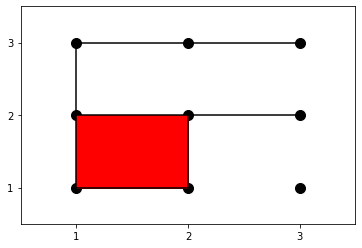

Value:  0
Value:  -1
Value:  1
Value:  0
Value:  -1
Value:  -1
Value:  1
Value:  1
Value:  1
Value:  -1
Number of nodes searched: 21


{'move': ('h', 1, 2), 'value': -1}

CPU times: total: 0 ns
Wall time: 2.01 ms


In [179]:
# Boards
DEBUG = 0
test1 = empty_small()
draw_line(test1, 'h', 3, 1, 1)
draw_line(test1, 'h', 3, 2, 1)
draw_line(test1, 'h', 2, 1, 1)
draw_line(test1, 'h', 2, 2, 1)
draw_line(test1, 'h', 1, 1, 1)
draw_line(test1, 'v', 3, 1, 1)
draw_line(test1, 'v', 2, 1, 1)
draw_line(test1, 'v', 2, 2, -1)
# draw_line(test1, 'v', 2, 3, 1)
# There is no win for 1 (blue) in this situation
# Best move: (v, 3, 2)
# Other moves: (v, 2, 3), (h, 1, 2), (v, 3, 3)
print_board(test1)
%time display(alpha_beta_search(test1))

Results:
         -1: 0
          1: 1


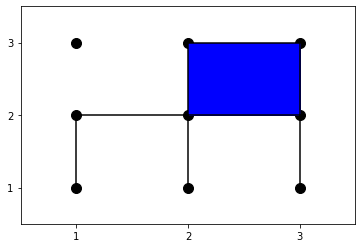

{'move': ('h', 1, 1), 'value': 1}

CPU times: total: 15.6 ms
Wall time: 996 µs


In [104]:
test2 = empty_small()
draw_line(test2, 'h', 3, 2, 1)
draw_line(test2, 'h', 2, 1, 1)
draw_line(test2, 'h', 2, 2, 1)
draw_line(test2, 'v', 3, 2, 1)
draw_line(test2, 'v', 3, 3, 1)
draw_line(test2, 'v', 2, 1, 1)
draw_line(test2, 'v', 2, 2, 1)
draw_line(test2, 'v', 2, 3, 1)
# Possible win for 1 (blue) in this situation
# Best moves: (h, 1, 1), (h, 1, 2)
# Bad moves: (v, 3, 1), (h, 3, 1)
print_board(test2)
%time display(alpha_beta_search(test2))

Results:
         -1: 0
          1: 0


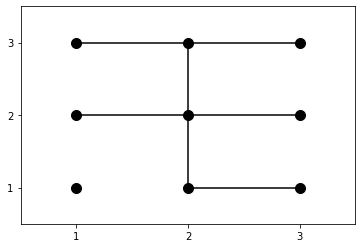

{'move': ('v', 2, 3), 'value': 0}

CPU times: total: 15.6 ms
Wall time: 1.32 ms


In [114]:
test3 = empty_small()
draw_line(test3, 'h', 3, 1, -1)
draw_line(test3, 'h', 3, 2, 1)
draw_line(test3, 'h', 2, 1, -1)
draw_line(test3, 'h', 2, 2, 1)
draw_line(test3, 'h', 1, 2, -1)
draw_line(test3, 'v', 3, 2, 1)
draw_line(test3, 'v', 2, 2, -1)
# Best moves: (v, 3, 1), (v, 3, 3), (v, 2, 3)
# Bad moves: (v, 2, 1), (h, 1, 1)
print_board(test3)
%time display(alpha_beta_search(test3))

Results:
         -1: 0
          1: 1


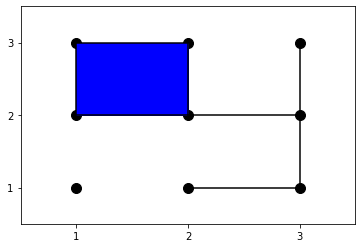

{'move': ('v', 2, 2), 'value': 0}

CPU times: total: 0 ns
Wall time: 998 µs


In [115]:
test4 = empty_small()
draw_line(test4, 'h', 3, 1, -1)
draw_line(test4, 'h', 2, 1, 1)
draw_line(test4, 'h', 2, 2, -1)
draw_line(test4, 'h', 1, 2, 1)
draw_line(test4, 'v', 3, 1, -1)
draw_line(test4, 'v', 3, 2, 1)
draw_line(test4, 'v', 3, 3, -1)
draw_line(test4, 'v', 2, 3, -1)
# Best moves: (v, 2, 2), (h, 3, 2)
# Bad moves: (v, 2, 1), (h, 1, 1)
print_board(test4)
%time display(alpha_beta_search(test4))

Results:
         -1: 2
          1: 0


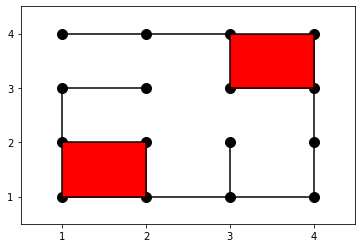

{'move': ('v', 3, 3), 'value': 1}

CPU times: total: 15.6 ms
Wall time: 5 ms


In [126]:
test5 = empty_board()
draw_line(test5, "h", 4, 1, -1)
draw_line(test5, "h", 4, 2, -1)
draw_line(test5, "h", 4, 3, -1)
draw_line(test5, "h", 3, 1, -1)
draw_line(test5, "h", 3, 3, -1)
draw_line(test5, "h", 2, 1, -1)
draw_line(test5, "h", 1, 1, -1)
draw_line(test5, "h", 1, 2, -1)
draw_line(test5, "h", 1, 3, -1)
# draw_line(test5, "v", 4, 2, -1)
draw_line(test5, "v", 4, 3, -1)
draw_line(test5, "v", 4, 4, -1)
draw_line(test5, "v", 3, 1, -1)
draw_line(test5, "v", 3, 4, -1)
draw_line(test5, "v", 2, 1, -1)
draw_line(test5, "v", 2, 2, -1)
draw_line(test5, "v", 2, 3, -1)
draw_line(test5, "v", 2, 4, -1)
# Best moves: (h, 2, 2), (v, 3, 2), (v, 3, 3), (h, 2, 3)
# Bad moves: (h, 3, 2), (v, 4, 1), (v, 4, 2), (h, 3, 2)
print_board(test5)
%time display(alpha_beta_search(test5))

Results:
         -1: 0
          1: 0


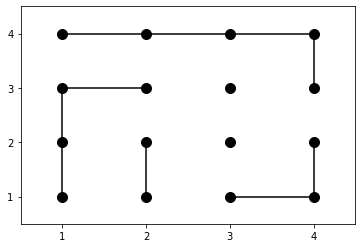

{'move': ('h', 1, 1), 'value': -1}

CPU times: total: 20.2 s
Wall time: 20.2 s


In [208]:
test6 = empty_board()
draw_line(test6, "h", 4, 1, -1)
draw_line(test6, "h", 4, 2, -1)
draw_line(test6, "h", 4, 3, -1)
draw_line(test6, "h", 3, 1, -1)
draw_line(test6, "h", 1, 3, -1)
draw_line(test6, "v", 4, 4, -1)
draw_line(test6, "v", 3, 1, -1)
draw_line(test6, "v", 2, 1, -1)
draw_line(test6, "v", 2, 2, -1)
draw_line(test6, "v", 2, 4, -1)

print_board(test6)
%time display(alpha_beta_search(test6))

### Time

How long does it take to make a move? Start with a smaller board make the board larger. What is the largest board you can solve?

The Alpha Beta Search can process a 3x3 board quickly.<br/>
However, that is also the largest board size it can solve in a reasonable time starting with a blank board as even a 4x4 takes too long.

In [181]:
# 3x3 board
DEBUG = -1
%time display(alpha_beta_search(empty_small()))

{'move': ('h', 1, 1), 'value': 0}

CPU times: total: 9.7 s
Wall time: 9.71 s


In [ ]:
# 4x4 board
%time display(alpha_beta_search(empty_board()))

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

One of the best strategies in Dots and Boxes is to make long chains so the player can complete many boxes sequentially, without losing his turn.<br/>
An acceptable move ordering is to consider creating a long chain on the left and right sides of the board.<br/>
To achieve that ordering, we will modify the `actions` function so it lists the vertical lines first so they can create these side chains.

In [217]:
import time

start = time.time()
alpha_beta_search(empty_small())
end = time.time()
no_sort_time1 = end - start

start = time.time()
alpha_beta_search(test6)
end = time.time()
no_sort_time2 = end - start

In [224]:
# Sorts by Vertical first
def actions(state):
    if terminal(state):
        return []
    
    # Get a list of all possible actions
    actions = []
    dots = state['n']*state['m']
    
    # Check all dots and orientations
    for row in range(state['n']):
        for col in range(state['m']):
            if ('v', row+1, col+1) not in state and (row+1) > 1:
                actions.insert(0, ('v', row+1, col+1))
            if ('h', row+1, col+1) not in state and (col+1) < (state['m']):
                # print('Column: ', col+1, ' M: ', state['m'])
                actions.append(('h', row+1, col+1))
    
    return actions

In [225]:
start = time.time()
alpha_beta_search(empty_small())
end = time.time()
sort_time1 = end - start

start = time.time()
alpha_beta_search(test6)
end = time.time()
sort_time2 = end - start

In [226]:
# Sorts by Horizontal first
def actions(state):
    if terminal(state):
        return []
    
    # Get a list of all possible actions
    actions = []
    dots = state['n']*state['m']
    
    # Check all dots and orientations
    for row in range(state['n']):
        for col in range(state['m']):
            if ('v', row+1, col+1) not in state and (row+1) > 1:
                actions.append(('v', row+1, col+1))
            if ('h', row+1, col+1) not in state and (col+1) < (state['m']):
                # print('Column: ', col+1, ' M: ', state['m'])
                actions.insert(0, ('h', row+1, col+1))
    
    return actions

In [227]:
start = time.time()
alpha_beta_search(empty_small())
end = time.time()
sort_h_time1 = end - start

start = time.time()
alpha_beta_search(test6)
end = time.time()
sort_h_time2 = end - start

In [228]:
import pandas as pd

table = pd.DataFrame({
'No Sorting': [no_sort_time1, no_sort_time2],
'Sorting by Vertical': [sort_time1, sort_time2],
'Sorting by Horizontal': [sort_h_time1, sort_h_time2]
}, index=[0, 1])
table

,No Sorting,Sorting by Vertical,Sorting by Horizontal
0,3.783758,8.109426,11.146569
1,7.071231,20.866912,28.429982


The table above shows that the sortings make the decision slower. So it is wiser to keep going with the original sorting.

In [229]:
# Return to original sorting
def actions(state):
    if terminal(state):
        return []
    
    # Get a list of all possible actions
    actions = []
    dots = state['n']*state['m']
    
    # Check all dots and orientations
    for row in range(state['n']):
        for col in range(state['m']):
            if ('v', row+1, col+1) not in state and (row+1) > 1:
                actions.append(('v', row+1, col+1))
            if ('h', row+1, col+1) not in state and (col+1) < (state['m']):
                # print('Column: ', col+1, ' M: ', state['m'])
                actions.append(('h', row+1, col+1))
    return actions

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

To prevent the agent from running all possible games from the start, the agent can insert a couple of random lines so the game gets started. Later, the agent will start calculating the best possible moves when there are fewer nodes to explore.

In [230]:
test6

{'n': 4,
 'm': 4,
 1: 0,
 -1: 0,
 ('h', 4, 1): True,
 ('h', 4, 2): True,
 ('h', 4, 3): True,
 ('h', 3, 1): True,
 ('h', 1, 3): True,
 ('v', 4, 4): True,
 ('v', 3, 1): True,
 ('v', 2, 1): True,
 ('v', 2, 2): True,
 ('v', 2, 4): True}

In [234]:
DEBUG = -1
COUNT = 0

def alpha_beta_search(state, player=1):
    global DEBUG, COUNT
    COUNT = 0
    
    # Check if state has less than 75% of lines drawn
    totalLines = ((board['n']-1) * 2) * ((board['m']-1) * 2)
    linesDrawn = 0
    
    for line in state:
        if line != 'n' and line != 'm' and type(line) != int:
            linesDrawn += 1
    
    if linesDrawn / totalLines < 0.70:
        # Choose a random line
        return random_player(state)
    
    
    val, move = max_value_ab(state, player, -math.inf, math.inf)
    
    if DEBUG >= 0: print(f"Number of nodes searched: {COUNT}") 
    
    return {'move': move, 'value': val}

def max_value_ab(state, player, alpha, beta):
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    
    if DEBUG >= 2: print("max in: " + str(state) + str([v]) ) 
    if v is not None: 
        if DEBUG >= 3: print(f"     found terminal state. backtracking.")
        if DEBUG >= 0: print('Value: ', v)
        return v, None
    
    v, move = -math.inf, None
    
    # check all possible actions in the state, return move with the largest value
    for a in actions(state):
        # print_board(state)
        v2, a2 = min_value_ab(result(state, a, player), player, alpha, beta)
        
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")

    if v is not None: 
        if DEBUG >= 3: print(f"     found terminal state. backtacking.")
        if DEBUG >= 0: print('Value: ', v)
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, a, -player), player, alpha, beta)
        
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        
        if v <= alpha:
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [250]:
play(alpha_beta_search, random_player, empty_board())

TypeError: 'dict' object cannot be interpreted as an integer

## Task 4: Heuristic Alpha-Beta Tree Search [30 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

An acceptable Heuristic Function can evaluate if the line will become the third line of a box. We want to avoid this situation because the opponent will be able to close that newly formed almost completed box and score a point on us.

In [ ]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Tournament task [+1 to 5% bonus on your course grade; will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [ ]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($5 \times 5$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [ ]:
# Your code/ answer goes here.